## Estimating functional connectivity from resting fMRI data

In this notebook we will examine how to estimate functional connectivity from resting fMRI data, using data from the Midnight Scan Club project.

In [17]:
import os,sys
import numpy,pandas
import matplotlib.pyplot as plt
import nilearn.plotting
import nilearn.input_data
import nilearn.datasets
import nilearn.connectome
import nibabel
from nibabel.gifti.gifti import GiftiImage,GiftiDataArray
import sklearn.preprocessing
import sklearn.linear_model
import sklearn.metrics
import scipy.stats
import networkx as nx
import bct

sys.path.append('../utils')
from utils import nx_to_igraph

%matplotlib inline

datadir = nilearn.datasets.get_data_dirs()[0]

sub=1
ses=2

subdir=os.path.join(datadir,'MSC/ds000224/derivatives/fmriprep/sub-MSC%02d/'%sub)

sesdir=os.path.join(subdir,'ses-func%02d/func'%ses)


# get freesurfer data if we don't already have it

fsaverage = nilearn.datasets.fetch_surf_fsaverage5()



We will start by loading the data that were processed using [fMRIPrep](http://fmriprep.org) for a single session.  This preprocessing include:

- motion correction
- spatial distortion correction
- spatial normalization to the MNI volume template and the FreeSurfer fsaverage5 template

We are going to use the data on the surface because we can then easily sample the data into the Glasser et al. MMP parcellation.



In [20]:
# load the preprocessed fMRI data

hemispheres=['L','R']
bold_origfile={}
ntp=818
nverts=10242  # number of vertices in fsaverage5 per hemisphere
bolddata_orig=numpy.zeros((ntp,nverts*2))
for i,h in enumerate(hemispheres):
    bold_origfile[h]=os.path.join(sesdir,'sub-MSC01_ses-func%02d_task-rest_bold_space-fsaverage5.%s.func.gii'%(ses,h))
    d=nibabel.load(bold_origfile[h]).darrays
    for tp in range(len(d)):
        bolddata_orig[tp,(i*nverts):((i+1)*nverts)]=d[tp].data
    
print('data shape:',bolddata_orig.shape)



data shape: (818, 20484)


### Confound regression

One of the common procedures applied to resting fMRI data is to regress out potential confounding variables. These include variables related to motion estimates and their temporal derivatives, as well as variables related to other signal components that are thought to be artifactual.  These can include:

- CSF signal
- white matter signal
- DVARS: a measure of changes in the global brain signal
- aCompCor: low-dimensional components within regions defined as non-GM (i.e. CSF and white matter)
- tCompCor: low-dimensional components within regions defined by having high temporal variability
- low frequency signals (usually below about .08 Hz)

These confounds are computed by fMRIprep and saved to a file alongside the data, which we load here.

/Users/poldrack/anaconda3/envs/py3/lib/python3.6/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


confound variables: Index(['CSF', 'WhiteMatter', 'GlobalSignal', 'stdDVARS', 'non-stdDVARS',
       'vx-wisestdDVARS', 'FramewiseDisplacement', 'tCompCor00', 'tCompCor01',
       'tCompCor02', 'tCompCor03', 'tCompCor04', 'tCompCor05', 'aCompCor00',
       'aCompCor01', 'aCompCor02', 'aCompCor03', 'aCompCor04', 'aCompCor05',
       'Cosine00', 'Cosine01', 'Cosine02', 'Cosine03', 'Cosine04', 'Cosine05',
       'Cosine06', 'Cosine07', 'Cosine08', 'Cosine09', 'Cosine10', 'Cosine11',
       'Cosine12', 'Cosine13', 'Cosine14', 'Cosine15', 'Cosine16', 'Cosine17',
       'Cosine18', 'Cosine19', 'Cosine20', 'Cosine21', 'Cosine22', 'Cosine23',
       'Cosine24', 'Cosine25', 'Cosine26', 'X', 'Y', 'Z', 'RotX', 'RotY',
       'RotZ', 'X_deriv', 'Y_deriv', 'Z_deriv', 'RotX_deriv', 'RotY_deriv',
       'RotZ_deriv'],
      dtype='object')


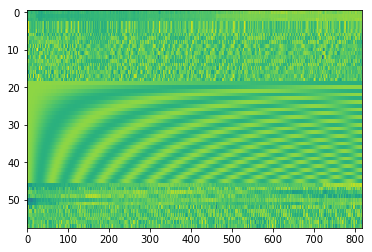

In [21]:
# load the confound data

confounds=pandas.read_csv(os.path.join(sesdir,
                        'sub-MSC01_ses-func%02d_task-rest_bold_confounds.tsv'%ses),
                         sep='\t',na_values='n/a')
confounds=confounds.replace(numpy.nan,0)
# add temporal derivatives of motion estimates
motionvars=['X', 'Y', 'Z', 'RotX', 'RotY', 'RotZ']
for v in motionvars:
    confounds['%s_deriv'%v]=0
    confounds['%s_deriv'%v].iloc[1:]=confounds[v].iloc[1:].values - confounds[v].iloc[:-1].values

print('confound variables:',confounds.columns)

plt.imshow(sklearn.preprocessing.scale(confounds).T,aspect='auto',
           cmap='viridis',interpolation='nearest')

Let's plot the data across all surface vertices next a measure of motion (Framewise Displacement).  This shows that motion tends to induce fairly large global signal changes, which persist even after motion correction.

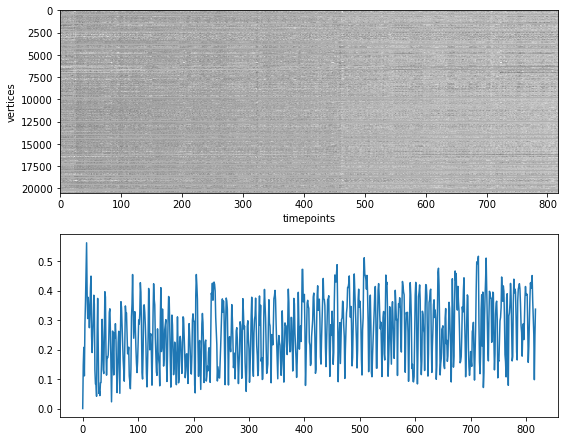

In [22]:
plt.figure(figsize=(8,6))

plt.subplot(2,1,1)
plt.imshow(sklearn.preprocessing.scale(bolddata_orig).T,aspect='auto',
           cmap='gray',interpolation='nearest')
plt.xlabel('timepoints')
plt.ylabel('vertices')
plt.tight_layout()

plt.subplot(2,1,2)

plt.plot(confounds.FramewiseDisplacement)



One of the most controversial aspects of resting fMRI data is whether one should regress out the global signal (i.e. the average signal across the whole brain).  Our approach is generally to perform any analyses with and without global signal regression (GSR) and ensure that any findings of interest exist in both analyses.  Here let's perform the confound regression.  Note that it is generally important to perform all regression and filtering operations in a single step - otherwise one can end up re-introducing artifactual signals.

In [23]:

# confounds with GSR
confounds_to_include = ['CSF', 'WhiteMatter', 'GlobalSignal', 'stdDVARS',
                        'FramewiseDisplacement', 'tCompCor00', 'tCompCor01',
                        'tCompCor02', 'tCompCor03', 'tCompCor04', 'tCompCor05', 
                        'aCompCor00','aCompCor01', 'aCompCor02', 'aCompCor03', 
                        'aCompCor04', 'aCompCor05',
                       'Cosine00', 'Cosine01', 'Cosine02', 'Cosine03', 'Cosine04', 'Cosine05',
                       'Cosine06', 'Cosine07', 'Cosine08', 'Cosine09', 'Cosine10', 'Cosine11',
                       'Cosine12', 'Cosine13', 'Cosine14', 'Cosine15', 'Cosine16', 'Cosine17',
                       'Cosine18', 'Cosine19', 'Cosine20', 'Cosine21', 'Cosine22', 'Cosine23',
                       'Cosine24', 'Cosine25', 'Cosine26', 'X', 'Y', 'Z', 'RotX', 'RotY', 'RotZ',
                       'X_deriv', 'Y_deriv', 'Z_deriv', 'RotX_deriv', 'RotY_deriv',
                       'RotZ_deriv']
confounds_gsr=confounds[confounds_to_include]

confounds_nogsr=confounds_gsr.copy()
del confounds_nogsr['GlobalSignal']

In [9]:
# perform confound regression with and without GSR

lr=sklearn.linear_model.LinearRegression(fit_intercept=False)

lr.fit(confounds_gsr.values,bolddata_orig)
bolddata_reg_gsr = bolddata_orig - lr.predict(confounds_gsr)

lr.fit(confounds_nogsr.values,bolddata_orig)
bolddata_reg_nogsr = bolddata_orig - lr.predict(confounds_nogsr)





/Users/poldrack/anaconda3/envs/py3/lib/python3.6/site-packages/sklearn/linear_model/base.py:509: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  linalg.lstsq(X, y)


Let's plot the vertex-wise data for both of these, which shows that the data without GSR still seem to show some global fluctuations.

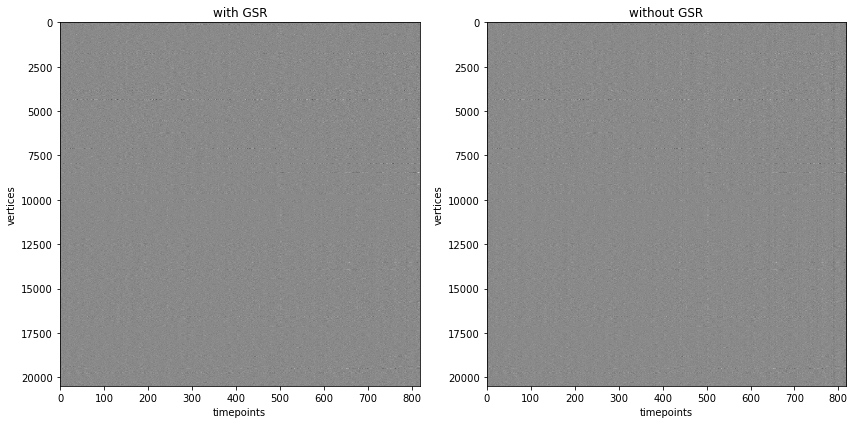

In [12]:
plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
plt.imshow(bolddata_reg_gsr.T,aspect='auto',cmap='gray',
          interpolation='nearest')
plt.xlabel('timepoints')
plt.ylabel('vertices')
plt.title('with GSR')
plt.tight_layout()

plt.subplot(1,2,2)

plt.imshow(bolddata_reg_nogsr.T,aspect='auto',cmap='gray',
          interpolation='nearest')
plt.xlabel('timepoints')
plt.ylabel('vertices')
plt.title('without GSR')
plt.tight_layout()




### extracting data from parcellation

In general we don't work with the data from each voxel/vertex, because (as we will discuss in more detail later in the course) there seems to be clear low-dimensional structure in the data.  Instead, we usually average over a smaller number of *parcels* that we think are related to one another.  For the present analysis we will use a group parcellation generated by Glasser et al. from the Human Connectome Project data. Let's extract the signal for all of the parcels from our data.

In [13]:
atlasdir='../data/HCP-MMP1'
atlas={'L':'lh.HCP-MMP1.fsaverage5.gii','R':'rh.HCP-MMP1.fsaverage5.gii'}
atlasdata={}
atlaslabels={}
for a in atlas:
   atlaslabeltable=nibabel.load(os.path.join(atlasdir,atlas[a])).labeltable.labels
   atlaslabels[a]=[i.label for i in atlaslabeltable[1:]]
   atlasdata[a]=nibabel.load(os.path.join(atlasdir,atlas[a])).darrays[0].data 
allatlaslabels=atlaslabels['L']+atlaslabels['R']
allatlasdata=numpy.hstack((atlasdata['L'],atlasdata['R']+180))
                          
  

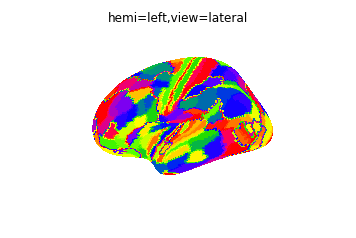

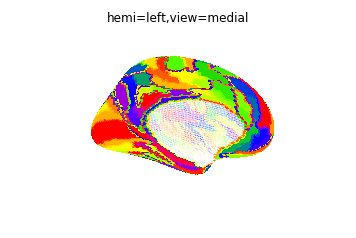

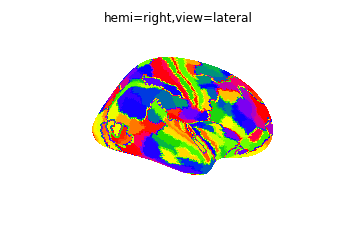

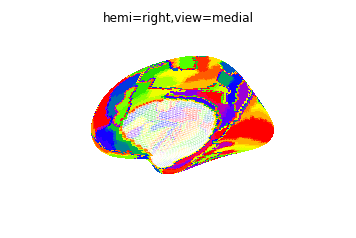

In [14]:
# plot each hemisphere/view

for i,hemi in enumerate(['left','right']):
    for view in ['lateral','medial']:
        plt.figure(figsize=(8,8))
        nilearn.plotting.plot_surf_stat_map(fsaverage['infl_%s'%hemi], 
                                    atlasdata[hemispheres[i]],
                                    thresh=0.5,
                                    hemi=hemi,
                                   view=view,cmap='prism')
        plt.title('hemi=%s,view=%s'%(hemi,view))


Let's extract the mean timeseries from each of the parcels.

In [15]:
roidata_gsr=numpy.zeros((ntp,361)) # 360 ROIs by 818 timepoints
roidata_nogsr=numpy.zeros((ntp,361)) # 360 ROIs by 818 timepoints

                        
for region in range(361):
    if region==0:
        continue
    regionverts=allatlasdata==region
    for tp in range(ntp):
      tmp=bolddata_reg_gsr[tp,:]
      roidata_gsr[tp,region]=numpy.mean(tmp[regionverts])
      tmp=bolddata_reg_nogsr[tp,:]
      roidata_nogsr[tp,region]=numpy.mean(tmp[regionverts])




### Motion scrubbing

In general, the effects of motion will persist even after the use of confound regression. For this reason, many investigators will censor (or *scrub*) the data by removing timepoints that exceed some particular threshold for motion, along with a number of following timepoints (since the effects of motion often persist for several timepoints).  

One common strategy is to identify timepoints that exceed a particular FD threshold (an aggressive choice advocated by Power and colleagues is FD>0.2; a less aggressive threshold commonly used is 0.5) along with some number of timepoints that follow those (with 10 being an aggressive number).  Note that scrubbing will interfere with analyses that require the full timeseries, but for simple correlations it doesn't cause any problems. Let's generate the temporal mask to identify and remove bad timeseries - we will use a less aggressive threshold but an aggressive window for removal of timepoints following motion.

In [16]:
fd_thresh=0.5
tps_exceeding_fd_thresh=numpy.where(confounds.FramewiseDisplacement.values>fd_thresh)
tswindow=10
tsmask=numpy.ones(confounds.shape[0])
for tp in tps_exceeding_fd_thresh[0]:
    tsmask[(tp-1):(tp+tswindow)]=0

print('%d good timepoints remaining after scrubbing (%d removed)'%(numpy.sum(tsmask),
                                                                   ntp-numpy.sum(tsmask)))



729 good timepoints remaining after scrubbing (89 removed)


Now we censor the masked timepoints

In [12]:
roidata_gsr_scrubbed=roidata_gsr[numpy.where(tsmask)[0],:]
roidata_nogsr_scrubbed=roidata_nogsr[numpy.where(tsmask)[0],:]



Let's look at the data from one parcel (in the left posterior cingulate cortex):

using region 30: L_POS1_ROI


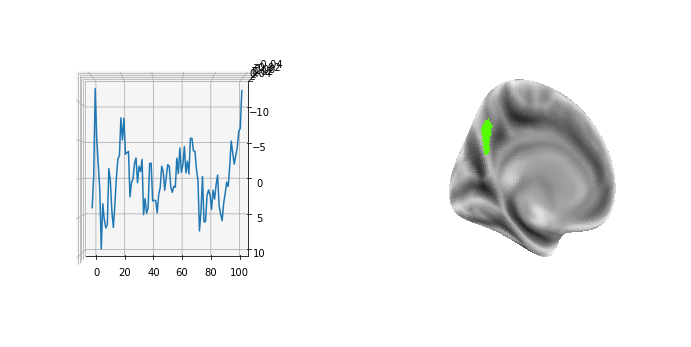

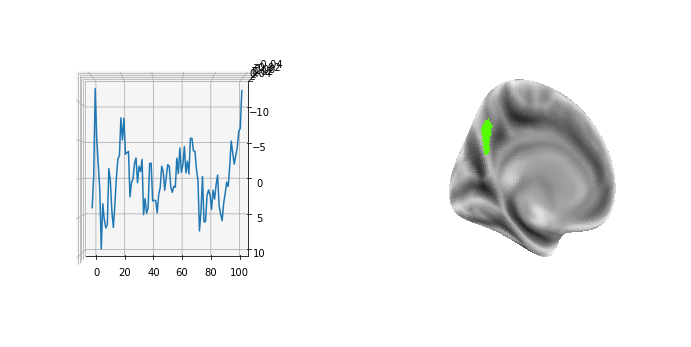

In [234]:
parcelnum=30
print('using region %d: %s'%(parcelnum,atlaslabels['L'][parcelnum]))
f,ax=plt.subplots(1,2,subplot_kw={"projection": "3d"},figsize=(12,6))
ax[0].view_init(270,270)
ntp_to_plot=100
ax[0].plot(range(ntp_to_plot),roidata_gsr[:ntp_to_plot,parcelnum],zs=0)

nilearn.plotting.plot_surf_roi(fsaverage['infl_left'], 
                                    (atlasdata['L']==parcelnum).astype('int'),thresh=0.5,
                                    hemi='left',bg_map=fsaverage['sulc_left'],
                                   view='medial',cmap='prism',axes=ax[1])



### Seed correlation

Let's compute the correlation between that particular parcel and all other parcels.

In [14]:

# standardize each parcel over time, so that we can compute correlation using standard linear regression
roidata_gsr_scrubbed_z=sklearn.preprocessing.scale(roidata_gsr_scrubbed)
lr=sklearn.linear_model.LinearRegression(fit_intercept=False)
lr.fit(roidata_gsr_scrubbed_z[:,parcelnum].reshape(-1,1),roidata_gsr_scrubbed_z)



LinearRegression(copy_X=True, fit_intercept=False, n_jobs=1, normalize=False)

In [15]:
# now create a new gifti image containing the correlation values, so we can visualize them

# first we need to map the parcel data back into vertices
corrdata_vertices=numpy.zeros(allatlasdata.shape)
for i in list(numpy.unique(allatlasdata)):
    corrdata_vertices[allatlasdata==i]=lr.coef_[int(i)]



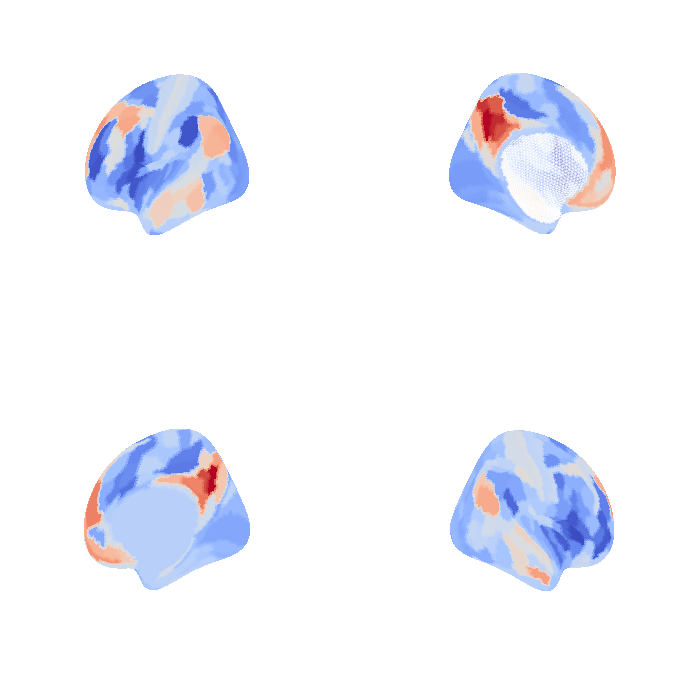

In [239]:
corrimg={}
hemis_text=['left','right']
for i,h in enumerate(hemispheres):
    corrimg[h]=GiftiImage(header=nibabel.load(fsaverage['infl_%s'%hemis_text[i]]).header)
    corrimg[h].add_gifti_data_array(GiftiDataArray(corrdata_vertices[i*nverts:(i+1)*nverts]))

f,ax=plt.subplots(2,2,subplot_kw={"projection": "3d"},figsize=(12,12))

for i,h in enumerate(hemispheres):
    for j,view in enumerate(['lateral','medial']):
        nilearn.plotting.plot_surf_stat_map(fsaverage['infl_%s'%hemis_text[i]],
                                            corrimg[h].darrays[0].data,
                                           view=view,axes=ax[i,j],
                                            colorbar=True)



### Whole-brain correlation

Now let's compute the correlation between all parcels.

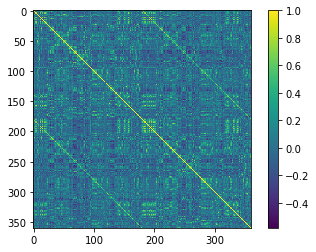

In [202]:
tscorr_gsr=numpy.corrcoef(roidata_gsr_scrubbed[:,1:].T) # drop the zero roi data
tscorr_nogsr=numpy.corrcoef(roidata_nogsr_scrubbed[:,1:].T) # drop the zero roi data

# we end up with a few NAN values because of an empty ROI, for now just zero them out
tscorr_gsr[numpy.isnan(tscorr_gsr)]=0
tscorr_nogsr[numpy.isnan(tscorr_nogsr)]=0

plt.imshow(tscorr_gsr)
plt.colorbar()

It's clear from looking at the data that there is substantial structure in the correlations.  To see this more clearly, let's reorganize the data using the network assignments that were given to the regions on the basis of resting state correlation structurea by Yeo et al. (2011).

In [240]:
# created previously using get_yeo_assignments.py
labelfile=os.path.join(atlasdir,'MMP_yeo2011_networks.csv')
labeldata=pandas.read_csv(labelfile)

In [241]:
def reorder_corrs(corrmtx,labeldata,labels='YeoDesc7'):
    """
    reorder correlation matrix according to network labels
    """
    
    idx=numpy.lexsort(([i for i in range(labeldata.shape[0])],labeldata[labels]))
    tmp=corrmtx[:,idx]
    return(tmp[idx,:],labeldata.iloc[idx,:])

def plot_reordered_corrs(corrmtx,labeldata,labels='YeoDesc7',colorbar=True):
    """
    plot correlation matrix after reordering
    """

    corr_reord,labeldata_reord=reorder_corrs(corrmtx,labeldata)
    plt.imshow(corr_reord)
    # find breakpoints and plot lines
    breaks=numpy.array([int(not i) for i in labeldata_reord[labels].values[:-1]==labeldata_reord[labels].values[1:]])
    breaklocs=numpy.hstack((numpy.where(breaks)[0],numpy.array(corrmtx.shape[0]-1)))
    for b in breaklocs:
        plt.plot([0,corrmtx.shape[0]-1],[b,b],color='w',linewidth=0.5)
        plt.plot([b,b],[0,corrmtx.shape[0]-1],color='w',linewidth=0.5)
    # find label locations
    # add a zero to help find label locations 
    breaklocs2=numpy.hstack(([0],breaklocs))
    label_locs=numpy.mean(numpy.vstack((breaklocs,breaklocs2[:-1])),0)
    networks=labeldata_reord[labels].values[breaklocs]
    ax=plt.gca()
    ax.set_yticks(label_locs)
    ax.set_yticklabels(networks)
    if colorbar:
        plt.colorbar()



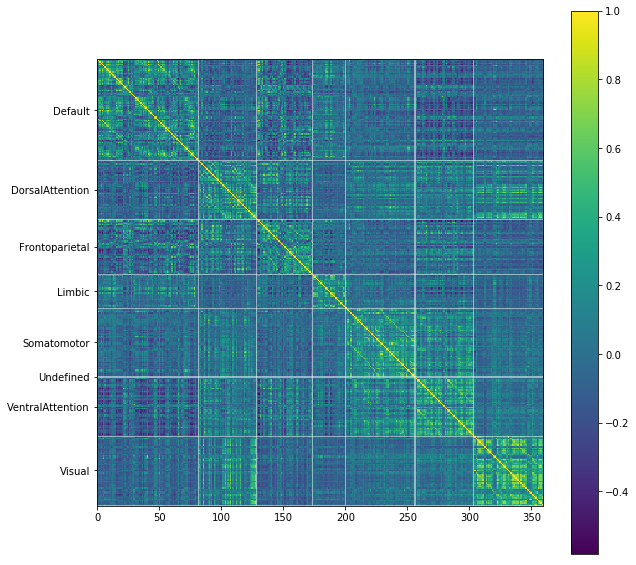

In [242]:
plt.figure(figsize=(10,10))
plot_reordered_corrs(tscorr_gsr,labeldata)

### Effects of global signal regression

There is often a substantial global component in resting state data, which in many cases is due to motion or breathing (e.g. [Power et al., 2017](https://www.ncbi.nlm.nih.gov/pubmed/27751941)). Let's plot the histogram of correlations to see how they are changed by GSR:

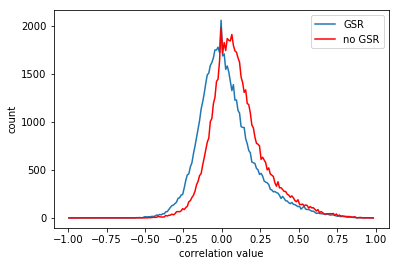

In [28]:
h_gsr=numpy.histogram(tscorr_gsr[numpy.triu_indices_from(tscorr_gsr,1)],numpy.arange(-1,1,0.01))
h_nogsr=numpy.histogram(tscorr_nogsr[numpy.triu_indices_from(tscorr_gsr,1)],numpy.arange(-1,1,0.01))

plt.plot(numpy.arange(-0.995,0.995,0.01),h_gsr[0])
plt.plot(numpy.arange(-0.995,0.995,0.01),h_nogsr[0],color='red')
plt.xlabel('correlation value')
plt.ylabel('count')
plt.legend(['GSR','no GSR'])

This shows that GSR substantially shifts the distribution of correlations towards the left.  Now let's compare the correlation values with and without GSR:

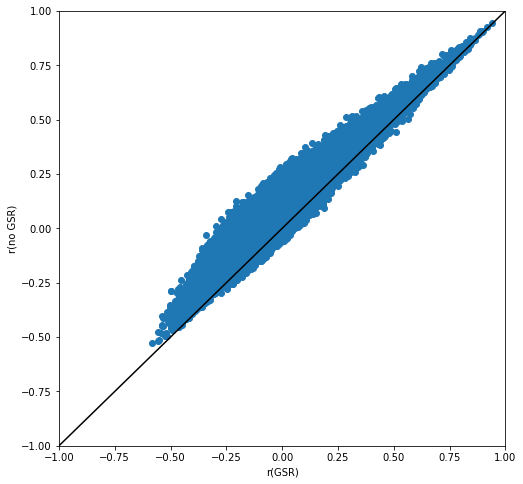

In [51]:
plt.figure(figsize=(8,8))
plt.scatter(tscorr_gsr[numpy.triu_indices_from(tscorr_gsr,1)],
        tscorr_nogsr[numpy.triu_indices_from(tscorr_gsr,1)],)
plt.plot([-1,1],[-1,1],'k-')
plt.axis([-1,1,-1,1])
plt.xlabel('r(GSR)')
plt.ylabel('r(no GSR)')


This shows that GSR generally reduces correlation values across the entire distribution of correlations.

### Network analysis

Now let's generate a graph based on the functional connectivity data that we generated above.  We will start by thresholding the correlation matrix to generate an adjacency matrix, and then generating a graph from that. Thresholding is necessarily arbitrary; we will choose the top 5% of edges.

cutoff:0.503


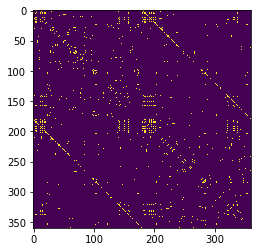

In [150]:
def get_adjmtx(corrmtx,density,verbose=False):
    assert density<=1
    cutoff=scipy.stats.scoreatpercentile(corrmtx[numpy.triu_indices_from(corrmtx,1)],
                                         100-(100*density))
    if verbose:
        print('cutoff:%0.3f'%cutoff)
    adjmtx=(corrmtx>cutoff).astype('int')
    adjmtx[numpy.diag_indices_from(adjmtx)]=0
    return(adjmtx)

adjmtx=get_adjmtx(tscorr_gsr,.025,verbose=True)
plt.imshow(adjmtx)

cutoff:0.503
Giant component includes 315 out of 360 total nodes
black : Undefined
red : Visual
yellow : Somatomotor
green : DorsalAttention
blue : VentralAttention
orange : Limbic
gray : Frontoparietal
magenta : Default


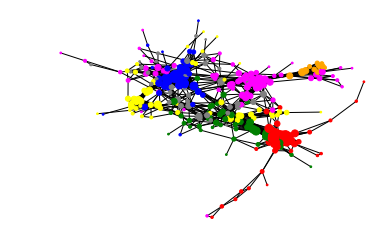

In [155]:
# now generate a graph using NetworkX
adjmtx=get_adjmtx(tscorr_gsr,.025,verbose=True)
G=nx.from_numpy_array(adjmtx)

# get giant component
comps=[i for i in nx.connected_component_subgraphs(G)]
Gc=comps[0]
print('Giant component includes %d out of %d total nodes'%(len(Gc.nodes),len(G.nodes)))
labeldata_Gc=labeldata.loc[list(Gc.nodes)]


cl={0:'black',1:'red',2:'yellow',3:'green',4:'blue',5:'orange',6:'gray',7:'magenta'}
colors=[cl[labeldata['Yeo'].iloc[i]] for i in Gc.nodes]
degrees=numpy.array([Gc.degree(i) for i in Gc.nodes])
expansion=3
layout=nx.spring_layout(Gc)
nx.draw_networkx(Gc,pos=layout,with_labels=False,node_color=colors,
              node_size=degrees*expansion)
_=plt.axis('off')
yeodict={0:'Undefined',1:'Visual',2:'Somatomotor',3:'DorsalAttention',
         4:'VentralAttention',5:'Limbic',
         6:'Frontoparietal',7:'Default'}

for i in yeodict:
    print(cl[i],':',yeodict[i])

### Community detection

Now let's run our own community detection analysis on the data, to see how the inferred communities relate to the established Yeo et al. networks.

Multilevel modularity optimization identifed 15 communities
Adjusted Rand index compared to Yeo 7 networks: 0.356


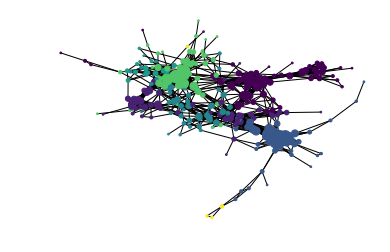

In [213]:
density=0.05
adjmtx=get_adjmtx(tscorr_gsr,density)
mod_binary=bct.modularity_louvain_und(adjmtx)


print('Multilevel modularity optimization identifed %d communities'%len(numpy.unique(mod_binary[0])))
ari=sklearn.metrics.adjusted_rand_score(vc.membership,labeldata_Gc['Yeo'])
print('Adjusted Rand index compared to Yeo 7 networks: %0.3f'%ari)

nx.draw_networkx(Gc,pos=layout,with_labels=False,node_color=[mod_binary[0][i] for i in Gc.nodes],
              node_size=degrees*expansion,cmap='viridis')

_=plt.axis('off')



### Weighted/signed networks

When we binarize a correlation to create an adjacency matrix, we are throwing away important information about negatively signed relationships, which we think are important in fMRI data.  There are generalizations of community detection methods that we can use for weighted and signed networks that can try to take advantage of this information.  Here we use a version of modularity optimization adapted from the [Brain Connectivity Toolbox](https://sites.google.com/site/bctnet/) (using the Python adaptation from https://github.com/aestrivex/bctpy)



In [214]:
mod_signed_weighted=bct.modularity_louvain_und_sign(tscorr_gsr)
print('signed/weighted analysis found %d communities (Q=%0.3f)'%(len(numpy.unique(mod_signed_weighted[0])),
                                                                 mod_signed_weighted[1]))
ari_yeo_ms=sklearn.metrics.adjusted_rand_score(mod_signed_weighted[0],[labeldata['Yeo'].iloc[i] for i in G.nodes])
print('Adjusted Rand index compared to Yeo 7 networks: %0.3f'%ari_yeo_ms)

print('')
print('binary analysis found %d communities (Q=%0.3f) at density=%0.3f'%(len(numpy.unique(mod_binary[0])),
                                                                 mod_binary[1],density))

ari=sklearn.metrics.adjusted_rand_score(mod_signed_weighted[0],mod_binary[0])

ari_yeo_bin=sklearn.metrics.adjusted_rand_score(mod_binary[0],[labeldata['Yeo'].iloc[i] for i in G.nodes])
print('Adjusted Rand index compared to Yeo 7 networks: %0.3f'%ari_yeo_bin)
print('')
print('Adjusted Rand index for weighted/signed vs binary: %0.3f'%ari)



signed/weighted analysis found 5 communities (Q=0.449)
Adjusted Rand index compared to Yeo 7 networks: 0.349

binary analysis found 15 communities (Q=0.649) at density=0.050
Adjusted Rand index compared to Yeo 7 networks: 0.433

Adjusted Rand index for weighted/signed vs binary: 0.544


### Partial correlation

Correlation is sensitive both to direct connections between regions as well as indirect connections.  Instead we might be interested in direct connections only, which can be estimated using partial correlation (also known as inverse covariance). Let's estimate that using the graphical lasso technique, which uses L1 regularization that imposes sparsity on the solution (i.e. many of the entries are zero).  

In [275]:
# this dataset has one roi with no variance, remove it before the analysis
roidata_gsr_scrubbed_nozero=roidata_gsr_scrubbed[:,numpy.arange(roidata_gsr_scrubbed.shape[1])!=120]

estimator=nilearn.connectome.ConnectivityMeasure(kind='partial correlation')
pcorr=estimator.fit_transform([roidata_gsr_scrubbed_nozero[:,1:]])   # drop the zero-ROI data
pcorr=pcorr[0]
pcorr[numpy.diag_indices_from(pcorr)]=0

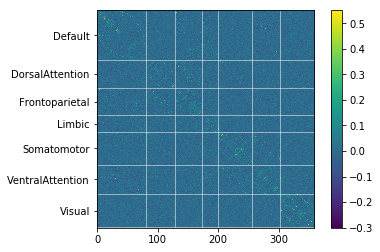

In [276]:
labeldata_cleaned=labeldata.copy()
labeldata_cleaned=labeldata_cleaned.drop(119)
plot_reordered_corrs(pcorr,labeldata_cleaned)

Multilevel modularity optimization identifed 7 communities
Adjusted Rand index compared to Yeo 7 networks: 0.356


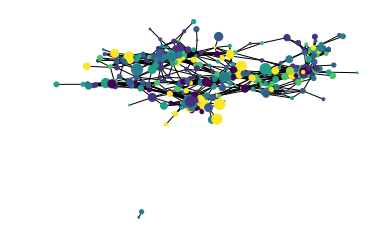

In [293]:
density=0.05
adjmtx=get_adjmtx(pcorr,density)
mod_binary_pcorr=bct.modularity_louvain_und(adjmtx)


print('Multilevel modularity optimization identifed %d communities'%len(numpy.unique(mod_binary[0])))
ari=sklearn.metrics.adjusted_rand_score(vc.membership,[labeldata['Yeo7'].iloc[i] for i in Gc.nodes])
print('Adjusted Rand index compared to Yeo 7 networks: %0.3f'%ari)

# need to drop node #120 from Gc
Gcc=Gc.copy()
Gcc.remove_node(120)
nx.draw_networkx(Gcc,with_labels=False,
                 node_color=[mod_binary_pcorr[0][i] for i in range(len(Gcc.nodes))],
              node_size=degrees*expansion,cmap='viridis')

_=plt.axis('off')




### Assessing functional connectivity using matrix factorization



In [294]:
from sklearn.decomposition import FastICA
fica=FastICA(n_components=40)
comps=fica.fit_transform(roidata_gsr_scrubbed.T)

In [301]:
def visualize_component(comps,compnum,
                        surf_meshfile,surf_sulcfile,
                        parcelmask,
                        hemispheres=['L','R'],
                       views=['lateral','medial'],
                       thresh=95):
    
    comp=comps[:,compnum]
    if thresh is not None:
        cutoff=scipy.stats.scoreatpercentile(comp,thresh)
    else:
        cutoff=0
    # first map from parcel space to vertex space
    parcel_ids=numpy.unique(parcelmask) 
    nvertices=int(len(parcelmask)/2)
    data=numpy.zeros(parcelmask.shape)
    for i in list(parcel_ids):
        data[parcelmask==i]=comp[int(i)]

    
    
    # display vertex space data
    f,ax=plt.subplots(2,2,subplot_kw={"projection": "3d"},figsize=(8,8))
    plt.subplots_adjust(wspace=0, hspace=0)


    for i,h in enumerate(hemispheres):
        for j,view in enumerate(views):
            nilearn.plotting.plot_surf_stat_map(fsaverage['infl_%s'%hemis_text[i]],
                                                data[i*nvertices:(i+1)*nvertices],
                                               view=view,axes=ax[i,j],
                                               bg_map=surf_sulcfile[h],
                                               threshold=cutoff)



In [296]:
visualize_component(comps,3,surf_meshfile,surf_sulcfile,parcelmask)

NameError: name 'surf_meshfile' is not defined